# TorchVision Instance Segmentation Finetuning Tutorial

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [ ]:
## %%shell --- Change %%shell to %%bash for own Ubuntu bash shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-dmgt2eit
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-dmgt2eit


In [1]:
# test env 
import os
import glob
from torch_snippets import *
from torch_snippets import Glob, stem, show, read
from PIL import Image
import pandas as pd
import torch
import torchvision
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
#import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for Penn-Fudan

Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [3]:
%%bash

## %%shell --- Change %%shell to %%bash for own Ubuntu bash shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
# extract it in the current folder
unzip PennFudanPed.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

--2022-03-10 20:03:38--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

     0K .......... .......... .......... .......... ..........  0% 96.9K 9m1s
    50K .......... .......... .......... .......... ..........  0% 27.9M 4m31s
   100K .......... .......... .......... .......... ..........  0%  196K 4m30s
   150K .......... .......... .......... .......... ..........  0% 16.2M 3m23s
   200K .......... .......... .......... .......... ..........  0%  198K 3m35s
   250K .......... .......... .......... .......... ..........  0% 41.3M 2m59s
   300K .......... .......... .......... .......... ..........  0% 46.2M 2m33s
   350K .......... .......... .......... .......... ..........  0% 25.

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

In [2]:

## See all options here -- https://pypi.org/project/psutil/
import psutil as psutil
from psutil import *


In [3]:
print(psutil.cpu_count())

8


In [4]:
print(psutil.cpu_count(logical=False))

8


In [5]:
print(psutil.cpu_stats())

scpustats(ctx_switches=113136984, interrupts=73074593, soft_interrupts=39173380, syscalls=0)


In [6]:
print(psutil.getloadavg())

(0.19, 0.16, 0.17)


In [3]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              8
On-line CPU(s) list: 0-7
Thread(s) per core:  1
Core(s) per socket:  8
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               158
Model name:          Intel(R) Core(TM) i7-9700F CPU @ 3.00GHz
Stepping:            13
CPU MHz:             2801.021
CPU max MHz:         4700.0000
CPU min MHz:         800.0000
BogoMIPS:            6000.00
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            12288K
NUMA node0 CPU(s):   0-7
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx est tm2 ssse3 sd

In [8]:
!nvidia-smi -L

GPU 0: GeForce GTX 1650 (UUID: GPU-7adafccf-3bac-a84f-09f7-2a7be0078a45)


In [4]:
! free -h --si

              total        used        free      shared  buff/cache   available
Mem:            32G        6.3G         19G        178M        7.2G         26G
Swap:          2.1G          0B        2.1G


In [5]:
!nvidia-smi

Sun Mar 20 15:32:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650    On   | 00000000:01:00.0  On |                  N/A |
|  0%   48C    P8     4W /  75W |    407MiB /  3910MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
"""
(pytorch_venv) dhankar@dhankar-1:~/.../face_recog22$ nvidia-smi -q -d "MEMORY"

==============NVSMI LOG==============

Timestamp                                 : Sat Mar 12 18:30:32 2022
Driver Version                            : 450.51.05
CUDA Version                              : 11.0

Attached GPUs                             : 1
GPU 00000000:01:00.0
    FB Memory Usage
        Total                             : 3910 MiB
        Used                              : 228 MiB
        Free                              : 3682 MiB
    BAR1 Memory Usage
        Total                             : 256 MiB
        Used                              : 9 MiB
        Free                              : 247 MiB

"""

'\n(pytorch_venv) dhankar@dhankar-1:~/.../face_recog22$ nvidia-smi -q -d "MEMORY"\n\n==============NVSMI LOG==============\n\nTimestamp                                 : Sat Mar 12 18:30:32 2022\nDriver Version                            : 450.51.05\nCUDA Version                              : 11.0\n\nAttached GPUs                             : 1\nGPU 00000000:01:00.0\n    FB Memory Usage\n        Total                             : 3910 MiB\n        Used                              : 228 MiB\n        Free                              : 3682 MiB\n    BAR1 Memory Usage\n        Total                             : 256 MiB\n        Used                              : 9 MiB\n        Free                              : 247 MiB\n\n'

In [6]:
!nvidia-smi -q -d "MEMORY"
### FOOBAR -- 3910MiB is almost 4GB of GPU "MEMORY"



==============NVSMI LOG==============

Timestamp                                 : Sun Mar 20 15:32:58 2022
Driver Version                            : 450.51.05
CUDA Version                              : 11.0

Attached GPUs                             : 1
GPU 00000000:01:00.0
    FB Memory Usage
        Total                             : 3910 MiB
        Used                              : 407 MiB
        Free                              : 3503 MiB
    BAR1 Memory Usage
        Total                             : 256 MiB
        Used                              : 11 MiB
        Free                              : 245 MiB



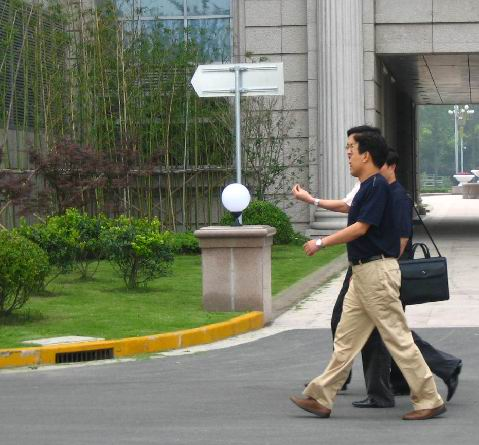

In [7]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00002.png')
Image.open('PennFudanPed/PNGImages/FudanPed00003.png')

In [10]:
#mask = Image.open('PennFudanPed/PedMasks/FudanPed00002_mask.png')
mask = Image.open('PennFudanPed/PedMasks/FudanPed00002_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's add a color palette to the mask.

#print("----type(mask----",type(mask)) # - <class 'PIL.PngImagePlugin.PngImageFile'>
#print("----type(mask----",mask.shape) #AttributeError: 'PngImageFile' object has no attribute 'shape'
# to get SHAPE of MASK convert to npArray 
mask_npArray = np.array(mask)
print("---mask_npArray.shape----",mask_npArray.shape) # - (414, 455)
print("---mask_npArray[0]----\n",mask_npArray[0]) # - (414, 455)


## https://pillow.readthedocs.io/en/stable/reference/ImagePalette.html

mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

# to get SHAPE of MASK convert to npArray 
mask_npArray = np.array(mask)
print("---mask_npArray.shape----",mask_npArray.shape) # - (414, 455)
print("---mask_npArray[0]----\n",mask_npArray[0]) # - (414, 455)

---mask_npArray.shape---- (414, 455)
---mask_npArray.shape----
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
---mask_npAr

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [18]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

## SGD Sampler ---> stochastic gradient decent (SGD),https://pytorch.org/docs/stable/data.html
## map-style-datasets ---> https://pytorch.org/docs/stable/data.html#map-style-datasets
## iterable-style-datasets --> https://pytorch.org/docs/stable/data.html#iterable-style-datasets

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        #print("----Image Sorted List ----",self.imgs)
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        print("---in HERE--__getitem__--")
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        
        img = Image.open(img_path).convert("RGB")
        #print("----type(img------",type(img)) ##-- <class 'PIL.Image.Image'>
        # note that we haven't converted the mask to RGB,because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        #print("----type(mask------",type(mask)) ## - <class 'numpy.ndarray'>
        
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        #print("----type(obj_ids-----",type(obj_ids)) #-- <class 'numpy.ndarray'>
        #print("----obj_ids.shape-----",obj_ids.shape)
        #print("----obj_ids-----",obj_ids)
        #
        
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]
        #print("-binary masks-----masks-----",masks)

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            print("-bounding box coordinates---pos-----",pos)
            print("   "*10)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            #print("---len(boxes---------",len(boxes))
            

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64) # there is only one class
        print("----labels[0]----",labels[0])
        print("   "*10)        
        #print("----labels[1]----",labels[1])#Index out of Bound 
        
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        print("----target-DICT---AREA of BBOX->>-\n",target["area"])

#         if self.transforms is not None: ### FOOBAR--Uncomment --Original Code
#             img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
    

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [19]:
dataset = PennFudanDataset('PennFudanPed/')

print(dataset[11]) ##(<PIL.Image.Image image mode=RGB size=468x384 at 0x7F48ED5141C0>,
#(<PIL.Image.Image image mode=RGB size=559x536 at 0x7FB7E4BDFF10>,
print(dataset[12]) 
print(dataset[13])
print(dataset[14])

### As seen below -- PIL IMAGE Dimensions are Not the same 



---in HERE--__getitem__--
-bounding box coordinates---pos----- (array([ 70,  70,  71, ..., 359, 360, 360]), array([224, 225, 224, ..., 271, 263, 264]))
                              
-bounding box coordinates---pos----- (array([ 57,  57,  57, ..., 326, 326, 326]), array([377, 378, 379, ..., 433, 434, 435]))
                              
----labels[0]---- tensor(1)
                              
----target-DICT---AREA of BBOX->>-
 tensor([39440., 29859.])
(<PIL.Image.Image image mode=RGB size=468x384 at 0x7F6CBEE53FA0>, {'boxes': tensor([[158.,  70., 294., 360.],
        [327.,  57., 438., 326.]]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

### 2 - Modifying the model to add a different backbone

Another common situation arises when the user wants to replace the backbone of a detection
model with a different one. For example, the current default backbone (ResNet-50) might be too big for some applications, and smaller models might be necessary.

Here is how we would go into leveraging the functions provided by torchvision to modify a backbone.

```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### An Instance segmentation model for PennFudan Dataset

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [22]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# ----type(model--- <class 'torchvision.models.detection.mask_rcnn.MaskRCNN'>
# --input features for the classifier>> -in_features--- 1024
# --TYPE-->> model.roi_heads....-- <class 'torchvision.models.detection.roi_heads.RoIHeads'>
# --TYPE-->> model.roi_heads.box_predictor.-- <class 'torchvision.models.detection.faster_rcnn.FastRCNNPredictor'>


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    print("----type(model---",type(model))
    
    #model_features_only = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).features
    #print("----type(model_features_only---",type(model_features_only))
    ## ModuleAttributeError: 'MaskRCNN' object has no attribute 'features'
    #

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #print("--input features for the classifier>> -in_features---",in_features)
    
    # whats the -->> model.roi_heads.# 
    print("-->> model.roi_heads....--",type(model.roi_heads))
    print("-->> model.roi_heads.box_predictor...--",type(model.roi_heads.box_predictor))
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model





In [23]:
# DONT RUN just testing above Prints 

#our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
print("---torch.cuda.memory_allocated---> {:.2f} GB".format(torch.cuda.memory_allocated()/1024**3))
## --torch.cuda.memory_allocated---> 0.00 GB


----type(model--- <class 'torchvision.models.detection.mask_rcnn.MaskRCNN'>
---torch.cuda.memory_allocated---> 0.00 GB


That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [19]:
%%bash

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [24]:
from engine import train_one_epoch, evaluate
#import utils ## Original here >> #import utils 
#import transforms as T ## this is the LOCAL Py Module - named transforms 

import torchvision.transforms as torchvision_transforms # Foobar_OwnCode

print("----testing import OK ---",type(train_one_epoch))
#esting import OK --- <class 'function'>


def get_transform(train):
    ls_transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    #transforms.append(T.ToTensor())
    
    #ls_transforms.append(torchvision_transforms.ToTensor())
    ls_transforms.append(torchvision_transforms.PILToTensor())
    ls_transforms.append(torchvision_transforms.Resize(256)) ## Foobar_OwnCode
    ls_transforms.append(torchvision_transforms.CenterCrop(224)) # Foobar_OwnCode
    print("--------ls_transforms--------",ls_transforms)
    
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        #transforms.append(T.RandomHorizontalFlip(0.5))
        print("---inTRAIN --Not Doing---RandomHorizontalFlip--")
        
    print("--torchvision_transforms.Compose(ls_transforms)->\n",torchvision_transforms.Compose(ls_transforms))
    return torchvision_transforms.Compose(ls_transforms)

print("---torch.cuda.memory_allocated---> {:.2f} GB".format(torch.cuda.memory_allocated()/1024**3))

----testing import OK --- <class 'function'>
---torch.cuda.memory_allocated---> 0.00 GB


#### Testing forward() method 

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [6]:
#import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed',get_transform(train=True))
print("-----Type(dataset-------",type(dataset))

### FOOBAR -- No Transforms 

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)

print("-----Type(data_loader-------",type(data_loader)) ##--- <class 'torch.utils.data.dataloader.DataLoader'>

print("--1-torch.cuda.memory_allocated---> {:.2f} GB".format(torch.cuda.memory_allocated()/1024**3))

## shuffle=True,

### FOOBAR --- setting num_workers > 0 enables asynchronous data loading 
## and overlap between the training and data loading. 
## num_workers should be tuned depending on the workload, CPU, GPU, and location of training data.

# For Training
try:
    images,targets = next(iter(data_loader))
except Exception as err_data_loader:
    print("----err_data_loader----",err_data_loader)
    pass







# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]

# output = model(images,targets)   # Returns losses and detections
# print("--2-torch.cuda.memory_allocated---> {:.2f} GB".format(torch.cuda.memory_allocated()/1024**3))

# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions

print("--3-torch.cuda.memory_allocated---> {:.2f} GB".format(torch.cuda.memory_allocated()/1024**3))


"""
/home/dhankar/anaconda3/envs/pytorch_venv/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/dhankar/anaconda3/envs/pytorch_venv/lib/python3.8/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)
"""


--------ls_transforms-------- [PILToTensor(), Resize(size=256, interpolation=bilinear, max_size=None, antialias=None), CenterCrop(size=(224, 224))]
---inTRAIN --Not Doing---RandomHorizontalFlip--
--torchvision_transforms.Compose(ls_transforms)->
 Compose(
    PILToTensor()
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
)
-----Type(dataset------- <class '__main__.PennFudanDataset'>
-----Type(data_loader------- <class 'torch.utils.data.dataloader.DataLoader'>
--1-torch.cuda.memory_allocated---> 0.00 GB
---in HERE--__getitem__-----in HERE--__getitem__--

---in HERE--__getitem__-----in HERE--__getitem__--

----TESTING---target-DICT->>-
----TESTING---target-DICT->>-
  {'boxes': tensor([[338.,  98., 507., 380.]]), 'labels': tensor([1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],


'\n/home/dhankar/anaconda3/envs/pytorch_venv/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. \n  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "\n/home/dhankar/anaconda3/envs/pytorch_venv/lib/python3.8/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:\n\tnonzero()\nConsider using one of the following signatures instead:\n\tnonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/python_arg_parser.cpp:766.)\n  keep = keep.nonzero().squeeze(1)\n'

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [6]:
# use our dataset and defined transformations
import utils

dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
print("--4---torch.cuda.memory_allocated---> {:.2f} GB".format(torch.cuda.memory_allocated()/1024**3))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
print("--5---torch.cuda.memory_allocated---> {:.2f} GB".format(torch.cuda.memory_allocated()/1024**3))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-5]) ## Original -- #-50
print("----type(dataset--------\n",type(dataset)) ## <class 'torch.utils.data.dataset.Subset'>

dataset_test = torch.utils.data.Subset(dataset_test, indices[-5:]) ## Original -- #-50

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

"""
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 
This DataLoader will create 4 worker processes in total. Our suggested max number of 
worker in current system is 2, which is smaller than what this DataLoader is going to create. 
Please be aware that excessive worker creation might get DataLoader 
running slow or even freeze, lower the worker number to avoid potential 
slowness/freeze if necessary.
  cpuset_checked))

"""

--------ls_transforms-------- [PILToTensor(), Resize(size=256, interpolation=bilinear, max_size=None, antialias=None), CenterCrop(size=(224, 224))]
---inTRAIN --Not Doing---RandomHorizontalFlip--
--torchvision_transforms.Compose(ls_transforms)->
 Compose(
    PILToTensor()
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
)
--4---torch.cuda.memory_allocated---> 0.00 GB
--------ls_transforms-------- [PILToTensor(), Resize(size=256, interpolation=bilinear, max_size=None, antialias=None), CenterCrop(size=(224, 224))]
--torchvision_transforms.Compose(ls_transforms)->
 Compose(
    PILToTensor()
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
)
--5---torch.cuda.memory_allocated---> 0.00 GB
----type(dataset--------
 <class 'torch.utils.data.dataset.Subset'>


'\n/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: \nThis DataLoader will create 4 worker processes in total. Our suggested max number of \nworker in current system is 2, which is smaller than what this DataLoader is going to create. \nPlease be aware that excessive worker creation might get DataLoader \nrunning slow or even freeze, lower the worker number to avoid potential \nslowness/freeze if necessary.\n  cpuset_checked))\n\n'

Now let's instantiate the model and the optimizer

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("--6---torch.cuda.memory_allocated---> {:.2f} GB".format(torch.cuda.memory_allocated()/1024**3))
# our dataset has two classes only - background and person
num_classes = 2
# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)
print("--7---torch.cuda.memory_allocated---> {:.2f} GB".format(torch.cuda.memory_allocated()/1024**3))
##--6---torch.cuda.memory_allocated---> 0.00 GB
##--7---torch.cuda.memory_allocated---> 0.17 GB
## Seen below -- nvidia-smi 
## |    0   N/A  N/A     22143      C   ...s/pytorch_venv/bin/python      839MiB |

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005) #ORIGINAL --> lr=0.005

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=1, #3 
                                               gamma=0.1)

--6---torch.cuda.memory_allocated---> 0.00 GB
--7---torch.cuda.memory_allocated---> 0.17 GB


In [13]:
!nvidia-smi 

Sun Mar 13 18:12:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650    On   | 00000000:01:00.0  On |                  N/A |
|  0%   48C    P0    16W /  75W |   1518MiB /  3910MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [9]:
# let's train it for 10 epochs
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from torch.optim.lr_scheduler import StepLR
num_epochs = 2 #10

#try:
   
for epoch in range(1,9,1):
    print("---epoch----",epoch)
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
        
# except Exception as err:
#     print("----Exception---err---",err)
#     pass

---epoch---- 1
-------train_one_epoch---model.train()--INHERE-----bbbb------
---in HERE--__getitem__-----in HERE--__getitem__-----in HERE--__getitem__--


---in HERE--__getitem__--
----TESTING---target-DICT->>-
 {'boxes': tensor([[174.,  24., 254., 320.],
        [290.,  33., 376., 329.]]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([61]), 'area': tensor([23680., 25456.]), 'iscrowd': tensor([0, 0])}
---in HERE--__getitem__--
----TESTING---target-DICT->>-
----TESTING---target-DICT->>-
  {'boxes': tensor([[231.,  

         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([45]), 'area': tensor([26691., 15691., 12871.,  6116.]), 'iscrowd': tensor([0, 0, 0, 0])}
Epoch: [1]  [  0/165]  eta: 0:02:17  lr: 0.005000  loss: 1.4974 (1.4974)  loss_classifier: 0.3881 (0.3881)  loss_box_reg: 0.3095 (0.3095)  loss_mask: 0.7821 (0.7821)  loss_objectness: 0.0119 (0.0119)  loss_rpn_box_reg: 0.0058 (0.0058)  time: 0.8358  data: 0.2435  max mem: 1401
--train_one_epoch--type(img_tensor----aaa---
 <class 'torch.Tensor'>
--train_one_epoch--type(cuda_tensor----bbb---
 <class 'torch.Tensor'>
torch.float32 <class 'torch.Tensor'> torch.FloatTensor
torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
--train_one_epoch--type(targets-------
 <class 'list'>


IndexError: list index out of range

Now that training has finished, let's have a look at what it actually predicts in a test image

In [12]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [13]:
prediction

[{'boxes': tensor([], device='cuda:0', size=(0, 4)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0'),
  'masks': tensor([], device='cuda:0', size=(0, 1, 349, 292))}]

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

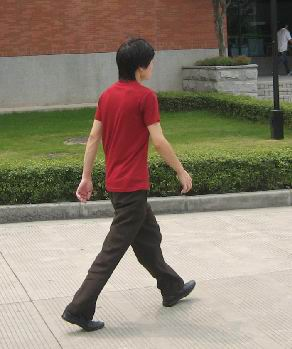

In [14]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

In [15]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

IndexError: index 0 is out of bounds for dimension 0 with size 0

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.8.2/references/detection). 

